[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cdrc1103/MasterThesis/blob/master/Experiments/MutiLabel/BERT_Ensemble_IPC.ipynb)

### Setup Notebook

In [ ]:
import tensorflow as tf
import os

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [2]:
%%capture
%matplotlib inline
!pip install wandb
!pip install -qq transformers
!pip install datasets

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Data & Parameters



In [4]:
import json
from pathlib import Path
import pandas as pd
import pickle
pd.options.mode.chained_assignment = None  # default='warn'

RUN_ID = "2.3_ATCI5000MIX"
BASE_DIR = Path(f"gdrive/MyDrive/Colab Notebooks/Thesis")
RUN_DIR = BASE_DIR / "MultiLabel/Runs"

# Load parameters
class Parameter():
  def __init__(self):
    self.__dict__ = {
      "project_name": "thesis_multi-label",
      "train_dataset": "train_ATCI5000MIX.csv",
      "test_dataset": "test_ATCI5000MIX.csv",
      "embedding_dataset": "bert-for-patents",
      "max_tokens": 39000, # vocabulary size
      "embedding_dim": 1024,
      "batch_size": 32,
      "learning_rate": 3e-5,
      "epochs": 2,
      "seed": 1, # random seed for reproducability
      "logging": True, # whether to log to the wandb database (True) or to disk (False)
      "n_classes": 18,
      "text_feature": ["abstract", "title", "claim"], # feature used for training
      "meta_feature": "ipc",
      "max_token_length": 30, # number of words/subwords, an instance is truncated to
      "out_feature": "label", # feature to predict
      "output_size": 1024, # output size of the language processing layer, i.e. the CNN, GRU etc. layer
      "dropout_rate": 0.1, # for regularization
      "threshold": 0.5,
      "ipc_file": "ipc_embeddings.p",
      "ipc_embedding_dim": 128,
      "ipc_token_length":7,
      "kernel_size": 3
    }

# Save to disk          
PARAMS = Parameter()
with open(RUN_DIR / f"{RUN_ID}.json", "w") as f:
  json.dump(PARAMS.__dict__, f)

all_features = PARAMS.text_feature.copy()
all_features.append(PARAMS.meta_feature)
# Read data sets
train_df = pd.read_csv(BASE_DIR / PARAMS.train_dataset, index_col=0)
train_df = train_df.sample(frac=1, random_state=PARAMS.seed).dropna()
ipc_train = train_df[PARAMS.meta_feature].apply(lambda x: eval(x))
x_train = train_df[PARAMS.text_feature]
y_train = train_df[train_df.columns.difference(all_features, sort=False)].to_numpy()
test_df = pd.read_csv(BASE_DIR / PARAMS.test_dataset, index_col=0)
test_df = test_df.sample(frac=1, random_state=PARAMS.seed).dropna()
ipc_test = test_df[PARAMS.meta_feature].apply(lambda x: eval(x))
x_test = test_df[PARAMS.text_feature]
y_test = test_df[test_df.columns.difference(all_features, sort=False)].to_numpy()

with open(BASE_DIR/PARAMS.ipc_file, "rb") as f:
    ipc_dict = pickle.load(f)

# Print stats
print(f"Train data set:{len(train_df)} instances")
print(f"Test data set:{len(test_df)} instances")

Train data set:213157 instances
Test data set:46464 instances


## Configure logging

In [40]:
# Logging
import wandb

# log to wandb
if PARAMS.logging:
    !wandb login
    run = wandb.init(project=PARAMS.project_name)
    run.name = RUN_ID
    log_dir = Path(wandb.run.dir)
    wandb.config.update(PARAMS.__dict__)
# log to disk
else:
    log_dir = RUN_DIR

wandb: Currently logged in as: cdrc1103 (use `wandb login --relogin` to force relogin)


## Model

In [6]:
""" Dependencies """
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Concatenate, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel, BertTokenizerFast, BertConfig
from datasets import Dataset
from tensorflow.keras.initializers import Constant

""" Configure tokenizer """
config = BertConfig.from_json_file(BASE_DIR/"bert_for_patents_large_config.json")
config.num_labels=PARAMS.n_classes
tokenizer = BertTokenizerFast(BASE_DIR/"bert_for_patents_vocab_39k.txt", config=config)

""" Create TF datasets """
# Aggregate features
x_train = Dataset.from_pandas(pd.DataFrame(x_train))
x_test = Dataset.from_pandas(pd.DataFrame(x_test))

# Tokenize
def tokenize(batch):
    return tokenizer(batch, truncation=True, padding=True, max_length=PARAMS.max_token_length)

x_train_tok = []
x_test_tok = []
for i, f in enumerate(PARAMS.text_feature):
  x_train_tok.append(x_train.map(tokenize, batched=True, batch_size=PARAMS.batch_size, input_columns=f))
  x_train_tok[i] = x_train_tok[i].rename_column("attention_mask", f"attention_mask{i}")
  x_train_tok[i] = x_train_tok[i].rename_column("input_ids", f"input_ids{i}")
  x_test_tok.append(x_test.map(tokenize, batched=True, batch_size=PARAMS.batch_size, input_columns=f))
  x_test_tok[i] = x_test_tok[i].rename_column("attention_mask", f"attention_mask{i}")
  x_test_tok[i] = x_test_tok[i].rename_column("input_ids", f"input_ids{i}")

# Create ipc embedding matrix
ipc_embedding_matrix = np.zeros([len(ipc_dict)+1, PARAMS.ipc_embedding_dim])
ipc_embedding_matrix[1:,:] = np.array(list(ipc_dict.values()))
# Index lookup
ipc_embedding_index = {k: v+1 for k, v in zip(ipc_dict.keys(), np.arange(0,len(ipc_dict)+1))}
# Tokenize ipc codes
def tokenize_ipc(row):
  token_array = np.zeros(PARAMS.ipc_token_length, dtype=np.int32)
  for i in range(PARAMS.ipc_token_length):
    if i == len(row):
      break
    token = ipc_embedding_index.get(row[i])
    if token:
      token_array[i] = token
  return token_array

ipc_train_tok = np.stack(ipc_train.apply(tokenize_ipc).values)
ipc_test_tok = np.stack(ipc_test.apply(tokenize_ipc).values)

# Create TF datasets
x_train_ds = {}
x_test_ds = {}

for i,f in enumerate(PARAMS.text_feature):
  # Transform to tensorflow data set
  x_train_tok[i].set_format(type='tensorflow', columns=[f'attention_mask{i}',f'input_ids{i}'])
  x_train_ds.update({x: x_train_tok[i][x].to_tensor(default_value=0) for x in [f'input_ids{i}', f'attention_mask{i}']})
  # Transform validation data set
  x_test_tok[i].set_format(type='tensorflow', columns=[f'attention_mask{i}',f'input_ids{i}'])
  x_test_ds.update({x: x_test_tok[i][x].to_tensor(default_value=0) for x in [f'input_ids{i}', f'attention_mask{i}']})

# Add ipc feature to x data set
x_train_ds.update({PARAMS.meta_feature: tf.convert_to_tensor(ipc_train_tok)})
x_test_ds.update({PARAMS.meta_feature: tf.convert_to_tensor(ipc_test_tok)})

train_ds = tf.data.Dataset.from_tensor_slices((x_train_ds, y_train)).batch(PARAMS.batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_ds, y_test)).batch(PARAMS.batch_size)

def build_model():

  # Textual features
  input_ids = []
  attention_mask = []
  embedding = []
  dropout = []
  input = {}

  transformer_model = TFBertModel.from_pretrained(BASE_DIR/"pytorch_model.bin", config=config, from_pt=True)

  for i, f in enumerate(PARAMS.text_feature):
    input_ids.append(Input(shape=PARAMS.max_token_length, name=f'input_ids{i}', dtype='int32'))
    attention_mask.append(Input(shape=PARAMS.max_token_length, name=f'attention_mask{i}', dtype='int32'))
    input[f"input_ids{i}"] = input_ids[i]
    input[f"attention_mask{i}"] = attention_mask[i]
    embedding.append(transformer_model.layers[0](input_ids[i], attention_mask=attention_mask[i])[1])
    dropout.append(Dropout(PARAMS.dropout_rate)(embedding[i]))
  
  # Meta features
  ipc_embedding = Embedding(
    ipc_embedding_matrix.shape[0],
    PARAMS.ipc_embedding_dim,
    embeddings_initializer=Constant(ipc_embedding_matrix),
    trainable=False
  )
  ipc_input = Input(shape=PARAMS.ipc_token_length, name=PARAMS.meta_feature, dtype='int32')
  input[PARAMS.meta_feature] = ipc_input
  embedded_sequences = ipc_embedding(ipc_input)
  x1 = Conv1D(PARAMS.output_size, PARAMS.kernel_size, activation="relu", padding='same')(embedded_sequences)
  x1 = GlobalMaxPooling1D()(x1)
  x1 = Dense(PARAMS.output_size, activation="relu")(x1)
  dropout.append(Dropout(PARAMS.dropout_rate)(x1))

  concat = Concatenate(axis=1)(dropout)
  output = Dense(PARAMS.n_classes, activation='sigmoid')(concat)
  return Model(inputs=input, outputs=output)

/usr/local/lib/python3.7/dist-packages/datasets/formatting/formatting.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(array, copy=False, **self.np_array_kwargs)


In [25]:
ipc_train.apply(lambda x: len(x)).max()

133

In [26]:
# Create ipc embedding matrix
ipc_embedding_matrix = np.zeros([len(ipc_dict)+1, PARAMS.ipc_embedding_dim])
ipc_embedding_matrix[1:,:] = np.array(list(ipc_dict.values()))
# Index lookup
ipc_embedding_index = {k: v+1 for k, v in zip(ipc_dict.keys(), np.arange(0,len(ipc_dict)+1))}
# Tokenize ipc codes
def tokenize_ipc(row):
  token_array = np.zeros(133, dtype=np.int32)
  for i in range(PARAMS.ipc_token_length):
    if i == len(row):
      break
    token = ipc_embedding_index.get(row[i])
    if token:
      token_array[i] = token
  return token_array

ipc_train_tok = np.stack(ipc_train.apply(tokenize_ipc).values)
ipc_test_tok = np.stack(ipc_test.apply(tokenize_ipc).values)

In [28]:
# Add ipc feature to x data set
x_train_ds.update({PARAMS.meta_feature: tf.convert_to_tensor(ipc_train_tok)})
x_test_ds.update({PARAMS.meta_feature: tf.convert_to_tensor(ipc_test_tok)})

train_ds = tf.data.Dataset.from_tensor_slices((x_train_ds, y_train)).batch(PARAMS.batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_ds, y_test)).batch(PARAMS.batch_size)

In [30]:
from tensorflow.keras.layers import Average

In [43]:
def build_model():

  # Textual features
  input_ids = []
  attention_mask = []
  embedding = []
  dropout = []
  input = {}

  transformer_model = TFBertModel.from_pretrained(BASE_DIR/"pytorch_model.bin", config=config, from_pt=True)

  for i, f in enumerate(PARAMS.text_feature):
    input_ids.append(Input(shape=PARAMS.max_token_length, name=f'input_ids{i}', dtype='int32'))
    attention_mask.append(Input(shape=PARAMS.max_token_length, name=f'attention_mask{i}', dtype='int32'))
    input[f"input_ids{i}"] = input_ids[i]
    input[f"attention_mask{i}"] = attention_mask[i]
    embedding.append(transformer_model.layers[0](input_ids[i], attention_mask=attention_mask[i])[1])
    dropout.append(Dropout(PARAMS.dropout_rate)(embedding[i]))
  
  # Meta features
  ipc_embedding = Embedding(
    ipc_embedding_matrix.shape[0],
    PARAMS.ipc_embedding_dim,
    embeddings_initializer=Constant(ipc_embedding_matrix),
    trainable=False
  )
  ipc_input = Input(shape=133, name=PARAMS.meta_feature, dtype='int32')
  input[PARAMS.meta_feature] = ipc_input
  embedded_sequences = ipc_embedding(ipc_input)
  embedded_average = GlobalAveragePooling1D()(embedded_sequences)
  embedded_dense = Dense(PARAMS.ipc_embedding_dim)(embedded_average)
  dropout.append(Dropout(PARAMS.dropout_rate)(embedded_dense))

  concat = Concatenate(axis=1)(dropout)
  output = Dense(PARAMS.n_classes, activation='sigmoid')(concat)
  return Model(inputs=input, outputs=output)

In [39]:
x_train_ds["ipc"].shape

TensorShape([213157, 133])

In [37]:
from tensorflow.keras.layers import GlobalAveragePooling1D
input_shape = (2, 3,4)
x = tf.random.normal(input_shape)
print(x)
y = tf.keras.layers.GlobalAveragePooling1D()(x)
print(y.shape)
print(y)

tf.Tensor(
[[[ 1.2561612   0.0814938   1.0053171  -0.7171143 ]
  [ 0.6295626   0.13979322 -2.7576678  -0.68654716]
  [-0.6656722   0.32839003 -0.77239513  0.44500697]]

 [[ 1.6547111   0.5826045   0.59905446 -0.2332386 ]
  [ 0.98633677 -0.96623826  0.05785945 -2.7172744 ]
  [-0.16769885  0.37430897  0.42950562 -0.37113473]]], shape=(2, 3, 4), dtype=float32)
(2, 4)
tf.Tensor(
[[ 0.4066839   0.18322568 -0.841582   -0.3195515 ]
 [ 0.8244497  -0.00310825  0.36213982 -1.107216  ]], shape=(2, 4), dtype=float32)


## Training

In [45]:
from tensorflow.keras.callbacks import TensorBoard
from wandb.keras import WandbCallback

""" Transfer to TPU """
with strategy.scope():
  model = build_model()
  optimizer = tf.keras.optimizers.Adam(learning_rate=PARAMS.learning_rate, epsilon=1e-08, clipnorm=1.0)
  loss = BinaryCrossentropy()
  metrics = [
    Precision(name='precision', thresholds=PARAMS.threshold), # Precision is the percentage of predicted positives that were correctly classified
    Recall(name='recall', thresholds=PARAMS.threshold) # Recall is the percentage of actual positives that were correctly classified
  ]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  # train the model
  history = model.fit(
    x=train_ds,
    epochs=PARAMS.epochs,
    verbose=1,
    validation_data=test_ds
    )

pd.DataFrame(history.history).to_csv(log_dir/"history.csv")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Epoch 1/2


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None, 133) dtype=int32>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None, 18) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 30) dty

6662/6662 [==============================] - ETA: 0s - loss: 0.1023 - precision: 0.8459 - recall: 0.7393

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None, 133) dtype=int32>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None, 18) dtype=int64>]


6662/6662 [==============================] - 1995s 250ms/step - loss: 0.1023 - precision: 0.8459 - recall: 0.7393 - val_loss: 0.0831 - val_precision: 0.8064 - val_recall: 0.7745
Epoch 2/2
6662/6662 [==============================] - 1449s 217ms/step - loss: 0.0514 - precision: 0.9181 - recall: 0.8861 - val_loss: 0.0774 - val_precision: 0.8299 - val_recall: 0.8075


In [46]:
from contextlib import redirect_stdout

""" Generate model summary """
print(model.summary())
with open(log_dir/'model_summary.txt', 'w') as file:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: file.write(x + '\n'))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ipc (InputLayer)                [(None, 133)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 133, 128)     2124544     ipc[0][0]                        
__________________________________________________________________________________________________
input_ids0 (InputLayer)         [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_mask0 (InputLayer)    [(None, 30)]         0                                            
____________________________________________________________________________________________

## Evaluate

In [47]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"]})
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, brier_score_loss, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import math

In [48]:
# Get predictions on test dataset
with strategy.scope():
  predictions = model.predict(
      x=test_ds,
      verbose=1,
      batch_size=PARAMS.batch_size
  ) # Probability distribution over the labels
np.savetxt(log_dir/"predictions.txt", predictions)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 30) dtype=int32>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None, 30) dtype=int64>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None, 133) dtype=int32>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None, 18) dtype=int64>]


1452/1452 [==============================] - 116s 62ms/step


In [49]:
ptopk = predictions.copy()
ptopk[ptopk > PARAMS.threshold] = 1
ptopk[ptopk <= PARAMS.threshold] = 0

metric_funcs = {
    "precision": Precision(thresholds=PARAMS.threshold),
    "recall" : Recall(thresholds=PARAMS.threshold)
}

metric_results ={}
for key, m in metric_funcs.items():
    m.update_state(y_test, ptopk)
    metric_results[key] = m.result().numpy()
if PARAMS.logging:
  wandb.log(metric_results)

In [50]:
# Hamming loss
def hamming_loss(pred_topk, truth):
    equals = pred_topk - truth
    equals = np.sum(1 - np.isin(equals, 0))
    return 1/(truth.shape[0]*truth.shape[1])*equals
if PARAMS.logging:
  wandb.log({"hamming_loss": hamming_loss(ptopk, y_test)})


In [51]:
# Exact match
def exact_match(pred_topk, truth):
    equals = pred_topk - truth
    equals = np.sum(equals, axis=1)
    return 1 - (np.count_nonzero(equals) / truth.shape[0])
if PARAMS.logging:
  wandb.log({"exact_match": exact_match(ptopk, y_test)})

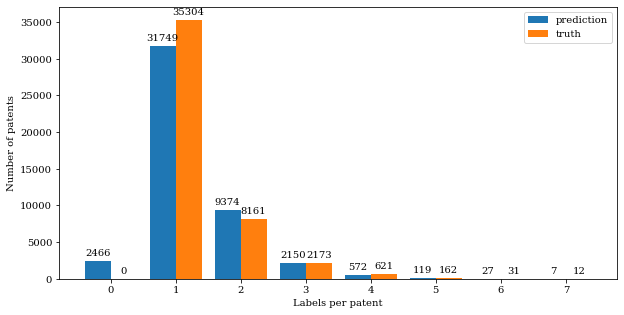

In [52]:
def count_labels(pred_topk, truth):
    # difference between number of predicted and true labels
    pred_sum = np.sum(pred_topk, 1)
    truth_sum = np.sum(truth, 1)
    fig, ax = plt.subplots(figsize=(10,5))
    width = 0.4
    pred_labels, pred_counts = np.unique(pred_sum, return_counts=True)
    pred_labels = pred_labels.astype(int)
    truth_labels, truth_counts = np.unique(truth_sum, return_counts=True)
    all_labels = np.arange(0, max(max(pred_labels), max(truth_labels))+1)
    new_pred_counts = np.zeros(len(all_labels))
    new_pred_counts[pred_labels] = pred_counts
    new_truth_counts = np.zeros(len(all_labels))
    new_truth_counts[truth_labels] = truth_counts 
    bars1 = ax.bar(all_labels - width/2, new_pred_counts, width=width, align='center')
    bars2 = ax.bar(all_labels + width/2, new_truth_counts, width=width, align='center')
    ax.set_xticks(all_labels)
    plt.legend(["prediction", "truth"])
    plt.xlabel("Labels per patent")
    plt.ylabel("Number of patents")

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(bars1)
    autolabel(bars2)
    plt.savefig(log_dir/"label_counts.png", dpi=150)
count_labels(ptopk, y_test)

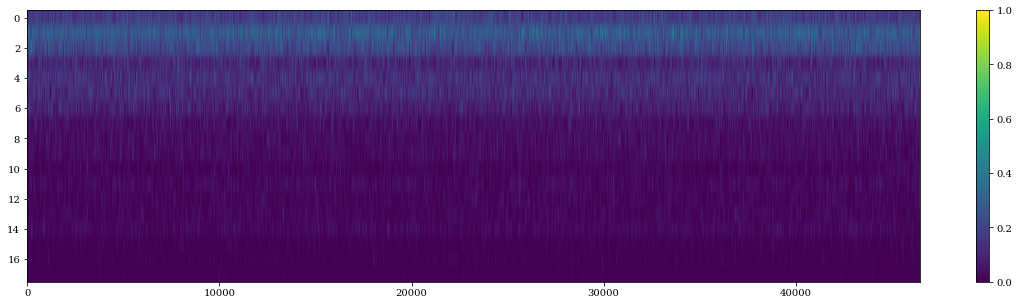

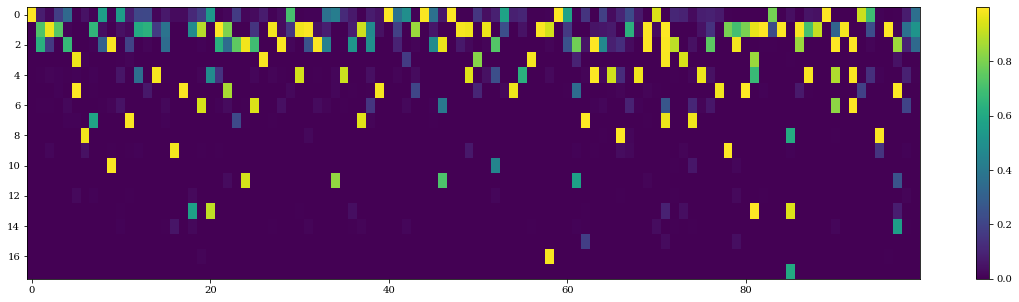

In [53]:
def plot_prediction_probs(pred_raw):
    # full set of predictions
    pic = pred_raw.transpose()
    fig = plt.figure(figsize=(20,5))
    im = plt.imshow(pic, aspect='auto')
    plt.colorbar(im)
    plt.savefig(log_dir/"prediction_probs.png", dpi=150)

    # subset of randomly selected predictions
    ids = np.random.randint(0,len(pred_raw),100)
    pic = pred_raw[ids,:].transpose()
    fig = plt.figure(figsize=(20,5))
    im = plt.imshow(pic, aspect='auto')
    plt.colorbar(im)
    plt.savefig(log_dir/"prediction_probs_100.png", dpi=150)
plot_prediction_probs(predictions)

In [54]:
# Calculate metrics per label
def create_report(true_label, pred_label, n_classes):
  cls_names =[str(cls) for cls in np.arange(0, n_classes)]
  cls_report = classification_report(true_label, pred_label, target_names=cls_names, output_dict=True)
  return pd.DataFrame(cls_report).round(2).transpose()

cls_report = create_report(y_test, ptopk, PARAMS.n_classes)
cls_report.to_csv(log_dir/"cls_report.csv")
if PARAMS.logging:
  wandb.log({"f1-score": cls_report["f1-score"].to_dict()})
cls_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.86,0.60,0.71,9044.0
1,0.89,0.82,0.85,14172.0
2,0.77,0.83,0.80,9448.0
3,0.89,0.90,0.89,5099.0
4,0.85,0.87,0.86,6151.0
5,0.80,0.93,0.86,4658.0
6,0.78,0.82,0.80,3680.0
7,0.87,0.78,0.82,2234.0
8,0.86,0.89,0.87,1575.0
9,0.86,0.83,0.84,1356.0


## Save loggings

In [55]:
""" Submit results """
if PARAMS.logging:
    run.join()
    run.finish()

precision,0.82995
recall,0.80752
_runtime,3981
_timestamp,1624830836
_step,3
hamming_loss,0.02641
exact_match,0.7848


precision,▁
recall,▁
_runtime,▁▁▁█
_timestamp,▁▁▁█
_step,▁▃▆█
hamming_loss,▁
exact_match,▁


In [56]:
model.save_weights(RUN_DIR/"ATC5000MIX.h5")
